In [1]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-06-20 18:21:52--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-06-20 18:21:52 ERROR 403: Forbidden.



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [5]:
df = pd.read_csv('bbc_text_cls.csv')

In [6]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [7]:
df['targets'] = df['labels'].astype("category").cat.codes

In [8]:
# number of classes
K = df['targets'].max() + 1
K

5

In [9]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [10]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [11]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 27463 unique tokens.


In [12]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (1557, 3487)


In [13]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 3487)


In [14]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [15]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['targets'],
  epochs=50,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/50
49/49 [==============================] - 19s 281ms/step - loss: 1.6002 - accuracy: 0.3064 - val_loss: 1.5773 - val_accuracy: 0.4192
Epoch 2/50
49/49 [==============================] - 12s 249ms/step - loss: 1.5013 - accuracy: 0.4817 - val_loss: 1.5581 - val_accuracy: 0.2246
Epoch 3/50
49/49 [==============================] - 10s 198ms/step - loss: 1.2280 - accuracy: 0.5742 - val_loss: 1.0733 - val_accuracy: 0.6198
Epoch 4/50
49/49 [==============================] - 10s 206ms/step - loss: 1.1346 - accuracy: 0.7303 - val_loss: 0.9008 - val_accuracy: 0.7635
Epoch 5/50
49/49 [==============================] - 10s 193ms/step - loss: 0.6678 - accuracy: 0.8510 - val_loss: 0.5379 - val_accuracy: 0.8787
Epoch 6/50
49/49 [==============================] - 8s 167ms/step - loss: 0.4073 - accuracy: 0.9294 - val_loss: 0.3949 - val_accuracy: 0.9087
Epoch 7/50
49/49 [==============================] - 7s 137ms/step - loss: 0.2670 - accuracy: 0.9531 - val_loss: 0.3199 - val_

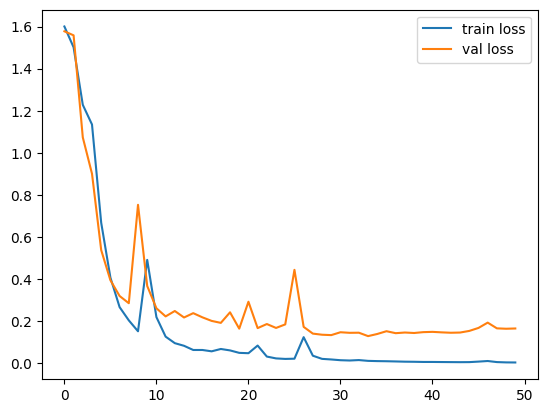

In [16]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

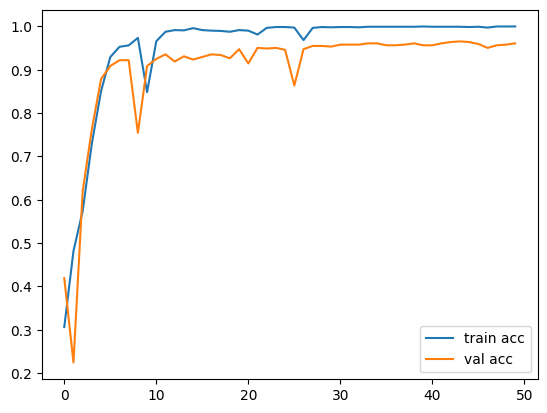

In [17]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();